In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [ ]:
#filename = 'fer2013.csv'
#label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv')
im=df['pixels']
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

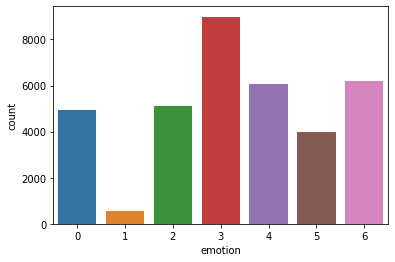

In [ ]:
sns.countplot(x = df.emotion)
plt.show()

In [ ]:
def augment_pixels(px, IMG_SIZE = 48):
    image = np.array(px.split(' ')).reshape(IMG_SIZE, IMG_SIZE).astype('float32')
    image = tf.image.random_flip_left_right(image.reshape(IMG_SIZE,IMG_SIZE,1))
    # Pad image size
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 12, IMG_SIZE + 12) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 1])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 255)
    augmented = image.numpy().reshape(IMG_SIZE,IMG_SIZE)
    str_augmented = ' '.join(augmented.reshape(IMG_SIZE*IMG_SIZE).astype('int').astype(str))
    return str_augmented

valcounts = df.emotion.value_counts()
valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
for emotion_idx, aug_count in valcounts_diff.iteritems():
    sampled = df.query("emotion==@emotion_idx").sample(aug_count, replace=True)
    sampled['pixels'] = sampled.pixels.apply(augment_pixels)
    df = pd.concat([df, sampled])
    print(emotion_idx, aug_count)

3 0
6 2791
4 2912
2 3868
0 4036
5 4987
1 8442


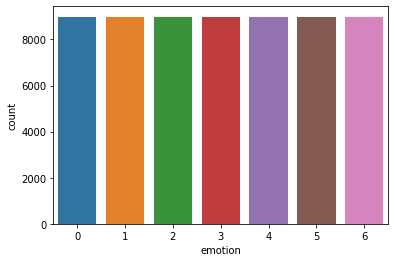

In [ ]:
sns.countplot(x = df.emotion)
plt.show()

In [ ]:
INTERESTED_LABELS = [0, 1, 2, 3, 4, 5, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(62923, 3)

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(62923, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(62923, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 7), (6293, 7))

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

In [ ]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='elu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='elu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='elu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='elu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='elu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='nadam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [ ]:
path_model='model_filter_2.h5' # save model at this location after each epoch
from keras import backend as K
K.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=50, 
            verbose=1, 
            validation_data=(X_valid,y_valid),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/50
885/885 [==============================] - 73s 43ms/step - loss: 1.7415 - accuracy: 0.3576 - val_loss: 1.3089 - val_accuracy: 0.5273
Epoch 2/50
885/885 [==============================] - 37s 42ms/step - loss: 1.1231 - accuracy: 0.5759 - val_loss: 1.1431 - val_accuracy: 0.5697
Epoch 3/50
885/885 [==============================] - 38s 42ms/step - loss: 0.9253 - accuracy: 0.6535 - val_loss: 0.9815 - val_accuracy: 0.6280
Epoch 4/50
885/885 [==============================] - 37s 42ms/step - loss: 0.7825 - accuracy: 0.7100 - val_loss: 1.1272 - val_accuracy: 0.5840
Epoch 5/50
885/885 [==============================] - 37s 42ms/step - loss: 0.6412 - accuracy: 0.7632 - val_loss: 1.0198 - val_accuracy: 0.6383
Epoch 6/50
885/885 [==============================] - 37s 42ms/step - loss: 0.4900 - accuracy: 0.8232 - val_loss: 1.1305 - val_accuracy: 0.6296
Epoch 7/50
885/885 [==============================] - 37s 42ms/step - loss: 0.3471 - accuracy: 0.8786 - val_loss: 1.1488 - val_accuracy:

 **Expression Prediction**

In [ ]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [ ]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [ ]:
model = tf.keras.models.load_model('model_filter_1.h5')

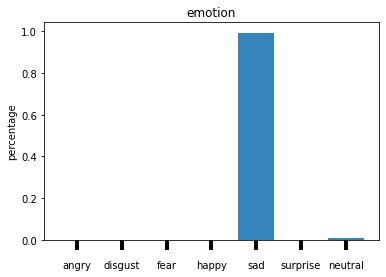

Expression Prediction: sad


In [ ]:
from skimage import io
img = image.load_img('/content/drive/My Drive/Kaggle/sad_2.jpg', color_mode = "grayscale", target_size=(48, 48))
show_img=image.load_img('/content/drive/My Drive/Kaggle/sad_2.jpg', color_mode = "rgb", target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

#plt.gray()
#plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

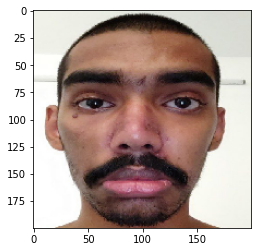

In [ ]:
plt.imshow(show_img)